In [1]:
import tensorflow as tf

import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
batch_size = 32
epochs = 5
filter_size = 3
group_1_dim = 32
group_2_dim = 64
group_3_dim = 128
dense_dim = 1024

dropout_rate = 0.2

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Users\kyley\Desktop\CS\C147\C147 Amazon Classification\img_uniform_split\train", 
                                                 labels='inferred', 
                                                 image_size=(64,64), 
                                                 batch_size=batch_size,
                                                 validation_split=0.2,
                                                 subset="training",
                                                 seed=123)

val_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Users\kyley\Desktop\CS\C147\C147 Amazon Classification\img_uniform_split\train", 
                                                 labels='inferred', 
                                                 image_size=(64,64), 
                                                 batch_size=batch_size,
                                                 validation_split=0.2,
                                                 subset="validation",
                                                 seed=123)

test_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Users\kyley\Desktop\CS\C147\C147 Amazon Classification\img_uniform_split\test", 
                                                 labels='inferred', 
                                                 image_size=(64,64), 
                                                 batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 89663 files belonging to 10 classes.
Using 71731 files for training.
Found 89663 files belonging to 10 classes.
Using 17932 files for validation.
Found 9966 files belonging to 10 classes.
['arts, crafts & sewing', 'books', 'clothing, shoes & jewelry', 'electronics', 'grocery & gourmet food', 'health & personal care', 'musical instruments', 'patio, lawn & garden', 'sports & outdoors', 'toys & games']


### Verify Distribution

In [4]:
count = np.zeros(10, dtype=np.int32)
for _, labels in train_ds:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
print(count)

[7171 7187 7006 7269 7187 7143 7162 7188 7085 7333]


In [5]:
def preprocess_data(X, Y):
  """
  Method:
      pre-processes the data for your model.
  """
  X_p = tf.keras.applications.inception_v3.preprocess_input(X)
  Y_p = tf.one_hot(Y, 10)

  return X_p, Y_p

# X_train_p, Y_train_p = preprocess_data(x_train, y_train)
# X_test_p, Y_test_p = preprocess_data(x_test, y_test)
train_ds = train_ds.map(preprocess_data)
val_ds = val_ds.map(preprocess_data)
test_ds = test_ds.map(preprocess_data)

In [12]:
base_inception = InceptionV3(include_top=False,
                             input_shape=(299, 299, 3))

input_layer = tf.keras.layers.Input(shape=(64, 64, 3))

resizing_layer = tf.keras.layers.Lambda(lambda image:                     \
                tf.keras.preprocessing.image.smart_resize(image, \
                (299, 299)))(input_layer)

# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal"),
#   tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
#   tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
#   tf.keras.layers.RandomZoom(height_factor=0.2)
# ])

# data_augmentation_layer = data_augmentation(resizing_layer)

inception_layers = base_inception(resizing_layer, training=False)

glob_pooling = tf.keras.layers.GlobalAveragePooling2D()(inception_layers)

layer_i = tf.keras.layers.Dense(500, activation='relu')(glob_pooling)

dropout_layer = tf.keras.layers.Dropout(0.3)(layer_i)

output_layer =  tf.keras.layers.Dense(10, activation='softmax')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)

In [15]:
import functools
top3_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'
top2_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=2)
top2_acc.__name__ = 'top2_acc'

In [13]:
# Freeze the base network
base_inception.trainable = False

model.compile(tf.keras.optimizers.Adam(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', top3_acc])

with tf.device('/gpu:0'):
        history = model.fit(
                train_ds,
                validation_data=val_ds,
                batch_size=300,
                epochs=4,
                verbose=1)

results = model.evaluate(test_ds)

Epoch 1/4


2242/2242 [==============================] - 283s 125ms/step - loss: 1.4424 - accuracy: 0.5080 - top3_acc: 0.7806 - val_loss: 1.2963 - val_accuracy: 0.5496 - val_top3_acc: 0.8224
Epoch 2/4
2242/2242 [==============================] - 282s 126ms/step - loss: 1.3298 - accuracy: 0.5486 - top3_acc: 0.8115 - val_loss: 1.3031 - val_accuracy: 0.5454 - val_top3_acc: 0.8175
Epoch 3/4
2242/2242 [==============================] - 289s 129ms/step - loss: 1.2881 - accuracy: 0.5597 - top3_acc: 0.8207 - val_loss: 1.2642 - val_accuracy: 0.5613 - val_top3_acc: 0.8285
Epoch 4/4
312/312 [==============================] - 31s 100ms/step - loss: 1.3001 - accuracy: 0.5580 - top3_acc: 0.8175


In [17]:
for layer in base_inception.layers[:164]:
  layer.trainable=False

for layer in base_inception.layers[164:]:
  layer.trainable=True

my_optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=my_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', top3_acc, top2_acc])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                    patience = 3, restore_best_weights = False)

checkpoint = tf.keras.callbacks.ModelCheckpoint(r'C:\Users\kyley\Desktop\CS\C147\amazon-product-classification\models\image\gln_checkpoint_top3.keras', 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

history = model.fit(
        train_ds,
        validation_data=val_ds,
        batch_size=32,
        epochs=1000,
        verbose=1,
        callbacks=[early_stop, checkpoint])

results = model.evaluate(test_ds)


Epoch 1/1000
2242/2242 [==============================] - ETA: 0s - loss: 1.2276 - accuracy: 0.5805 - top3_acc: 0.8357 - top2_acc: 0.7486
Epoch 1: val_loss improved from inf to 1.23768, saving model to C:\Users\kyley\Desktop\CS\C147\amazon-product-classification\models\image\gln_checkpoint_top3.keras
2242/2242 [==============================] - 284s 125ms/step - loss: 1.2276 - accuracy: 0.5805 - top3_acc: 0.8357 - top2_acc: 0.7486 - val_loss: 1.2377 - val_accuracy: 0.5779 - val_top3_acc: 0.8339 - val_top2_acc: 0.7467
Epoch 2/1000
2242/2242 [==============================] - ETA: 0s - loss: 1.1988 - accuracy: 0.5902 - top3_acc: 0.8435 - top2_acc: 0.7568
Epoch 2: val_loss did not improve from 1.23768
2242/2242 [==============================] - 282s 126ms/step - loss: 1.1988 - accuracy: 0.5902 - top3_acc: 0.8435 - top2_acc: 0.7568 - val_loss: 1.2432 - val_accuracy: 0.5732 - val_top3_acc: 0.8331 - val_top2_acc: 0.7478
Epoch 3/1000
2242/2242 [==============================] - ETA: 0s - los

In [18]:
import pandas as pd

predictions = predictions = model.predict(test_ds)
# print(predictions)

prediction_df = pd.DataFrame(predictions, columns=class_names)
# print(prediction_df.head())

predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

[5 0 1 ... 6 5 8]


[9 2 5 ... 5 3 7]


<Axes: xlabel='Predicted Label', ylabel='True Label'>

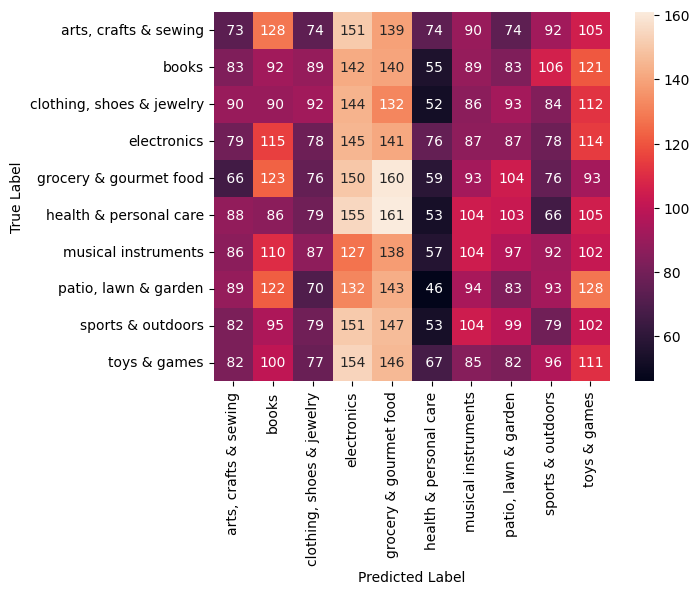

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create a confusion matrix
y_test = np.concatenate([y for x, y in test_ds], axis=0)
y_test =np.argmax(y_test, axis=1)
print(y_test)

cm = confusion_matrix(y_test, predicted_labels)

# Convert to a pandas dataframe
confusion_df = pd.DataFrame(cm, index=class_names, columns=class_names)
confusion_df.index.name = 'True Label'
confusion_df.columns.name = 'Predicted Label'

sns.heatmap(confusion_df, annot=True, fmt='3g')